In [1]:
# Step 1: Simulate Biased Coin Toss

import numpy as np

def coin_flips(n, prob_head=0.7):
    return np.random.choice(['H','T'], size=n, p=[prob_head, 1-prob_head])

tosses = coin_flips(10000, 0.7)

In [2]:
# 2. Frequentist Analysis
# Using Classical statistical tools to analyze outcomes

# a. Confidence interval for estimated probability

import statsmodels.stats.proportion as smp

heads = np.sum(np.array(tosses) == 'H')
ci_low, ci_upp = smp.proportion_confint(count=heads, nobs=len(tosses), alpha=0.05, method='wilson')
print(f"95% Confidence Interval for P(Head): ({ci_low:.4f}, {ci_upp:.4f})")

95% Confidence Interval for P(Head): (0.6829, 0.7010)


In [3]:
# b. Hypothesis Testing

from scipy.stats import binomtest

p_val = binomtest(heads, n=len(tosses), p=0.5, alternative='two-sided')
print(f"P-value for H0: {p_val.pvalue:4f}")

P-value for H0: 0.000000


In [4]:
# Calculate confidence intervals using different methods

methods=['normal', 'wilson', 'agresti_coull', 'beta']
ci_results = {}

for method in methods:
    ci_low, ci_upp = smp.proportion_confint(count=heads, nobs=len(tosses), alpha=0.05, method=method)
    ci_results[method] = (ci_low, ci_upp)
ci_results

{'normal': (0.6829515019632677, 0.7010484980367322),
 'wilson': (0.6828792113257258, 0.7009733332999342),
 'agresti_coull': (0.6828789110296211, 0.7009736335960391),
 'beta': (0.6828465410287404, 0.7010415210413068)}

In [5]:
# Bootstrap confidence interval

data = coin_flips(10000, 0.7)
phats = []

for _ in range(10000):
    sample = np.random.choice(data, size=len(data), replace=True)
    sample_numeric = np.array(sample) == 'H'
    phats.append(np.mean(sample_numeric))

lower = np.percentile(phats,100*(0.05/2))
upper = np.percentile(phats,100*(1-0.05/2))

ci_results['Bootstrap'] = (lower, upper)
ci_results

{'normal': (0.6829515019632677, 0.7010484980367322),
 'wilson': (0.6828792113257258, 0.7009733332999342),
 'agresti_coull': (0.6828789110296211, 0.7009736335960391),
 'beta': (0.6828465410287404, 0.7010415210413068),
 'Bootstrap': (0.691, 0.7091)}

In [6]:
# Power simulation: estimate power to detect bias for various sample sizes

sample_size = np.arange(10,301,10)
power = []

for n in sample_size:
    rejection = 0
    for _ in range(5000):
        data = coin_flips(n, 0.7)
        data_numeric = np.array(data) == 'H'
        heads = np.sum(data_numeric)
        pval = binomtest(k=heads, n=n, p=0.5, alternative='two-sided').pvalue
        if pval<0.05:
            rejection += 1
    power.append(rejection/5000)

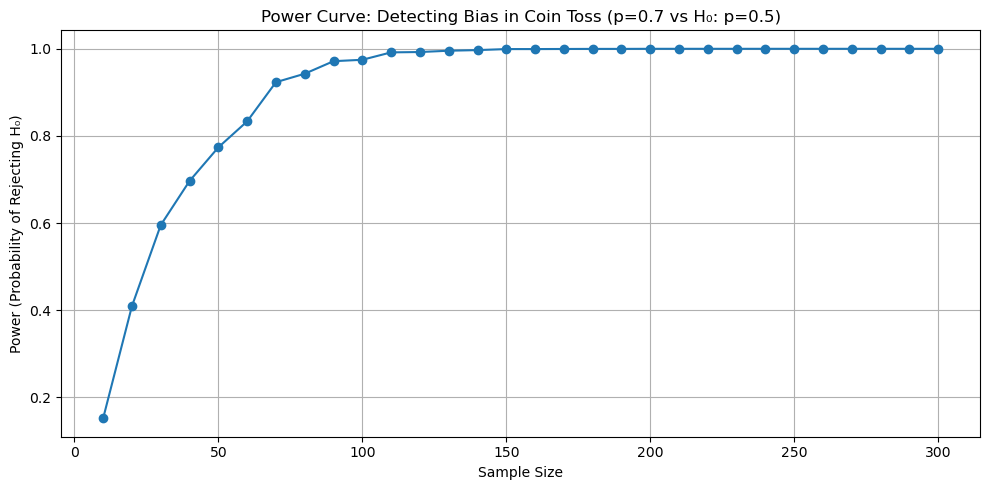

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(sample_size, power, marker='o')
plt.title("Power Curve: Detecting Bias in Coin Toss (p=0.7 vs H₀: p=0.5)")
plt.xlabel("Sample Size")
plt.ylabel("Power (Probability of Rejecting H₀)")
plt.grid(True)
plt.tight_layout()
plt.show()

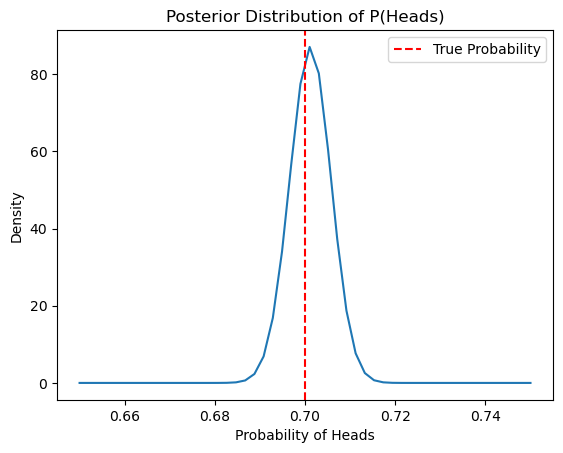

In [8]:
# 3. Bayesian Inference

# a. Set Prior and Posterior

import scipy.stats as st

#Prior: Beta(1,1) (uniform)
alpha_prior = 1
beta_prior = 1

tosses = coin_flips(10000, 0.7)
heads = np.sum(np.array(tosses) == 'H')

#Posterior update
alpha_post = alpha_prior + heads
beta_post = beta_prior + (len(tosses) - heads)

x = np.linspace(0.65,0.75,50)
posterior = st.beta.pdf(x, alpha_post, beta_post)

plt.plot(x, posterior)
plt.title("Posterior Distribution of P(Heads)")
plt.xlabel("Probability of Heads")
plt.ylabel("Density")
plt.axvline(x=0.7, color='r', linestyle='--', label='True Probability')
plt.legend()
plt.show()

In [9]:
# b. Posterior Summary Stats
mean_post = alpha_post/(alpha_post+beta_post)
print(f'Posterior mean: {mean_post:.4f}')

Posterior mean: 0.7012


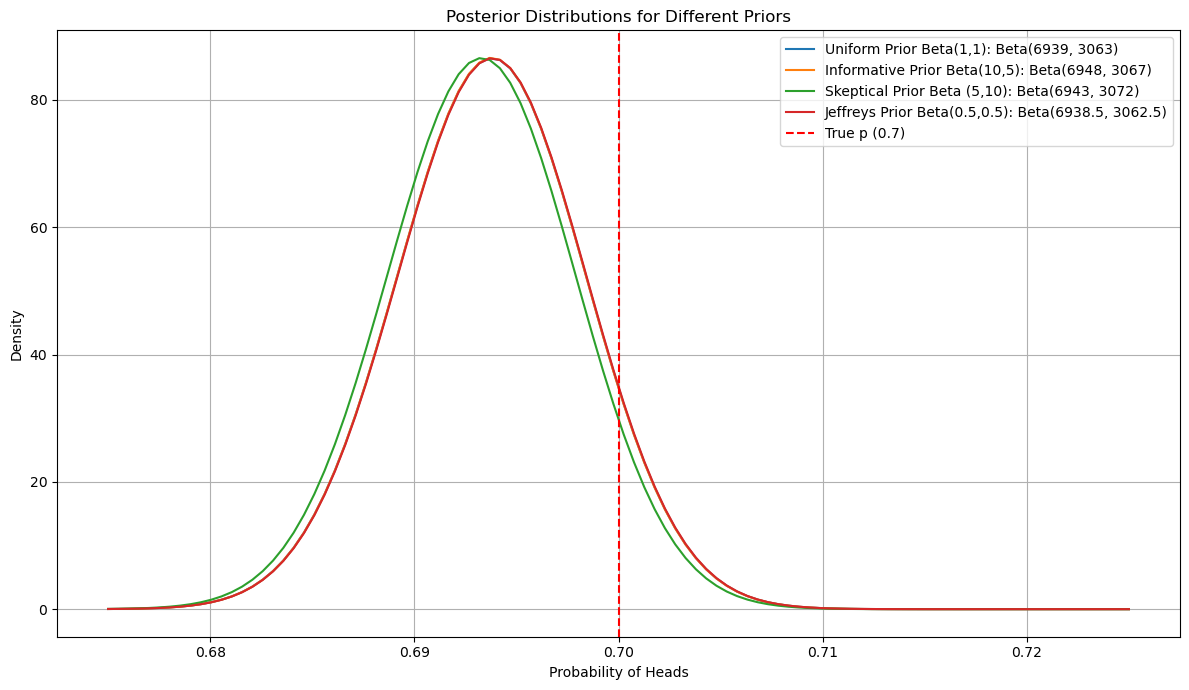

In [10]:
# Testing different priors in Bayesian Inference

priors = {
    "Uniform Prior Beta(1,1)": (1,1),
    "Informative Prior Beta(10,5)": (10,5),
    "Skeptical Prior Beta (5,10)": (5,10),
    "Jeffreys Prior Beta(0.5,0.5)": (0.5,0.5)
}

tosses = coin_flips(10000, 0.7)
heads = np.sum(np.array(tosses) == 'H')
tails = len(tosses) - heads

# Prepare posterior plots for each prior
x = np.linspace(0.675,0.725,100)
plt.figure(figsize=(12,7))

post = {}

for label, (a_prior, b_prior) in priors.items():
    a_post = a_prior + heads
    b_post = b_prior + tails
    post[label] = (a_post, b_post)
    posterior = st.beta.pdf(x, a_post, b_post)
    plt.plot(x, posterior, label=f'{label}: Beta({a_post}, {b_post})')

# Mark true value of p
plt.axvline(0.7, color='red', linestyle='--', label='True p (0.7)')
plt.title("Posterior Distributions for Different Priors")
plt.xlabel("Probability of Heads")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

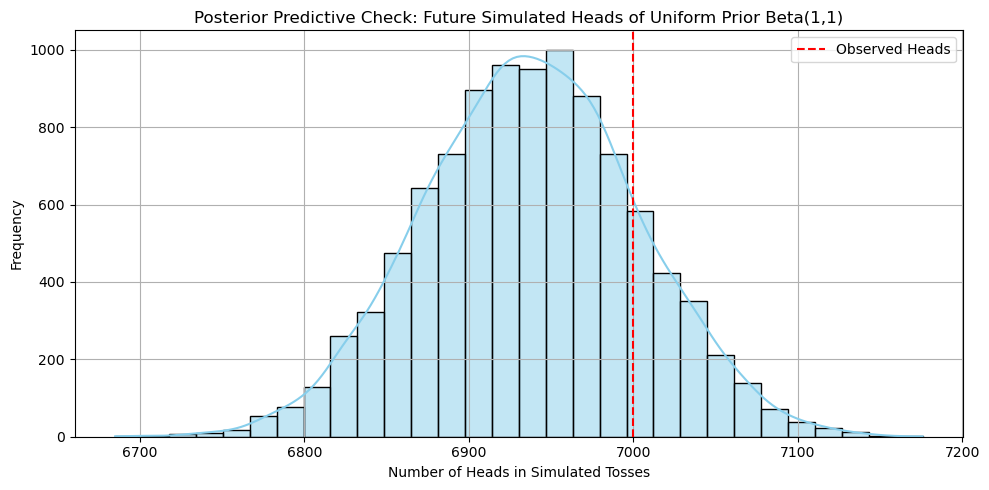

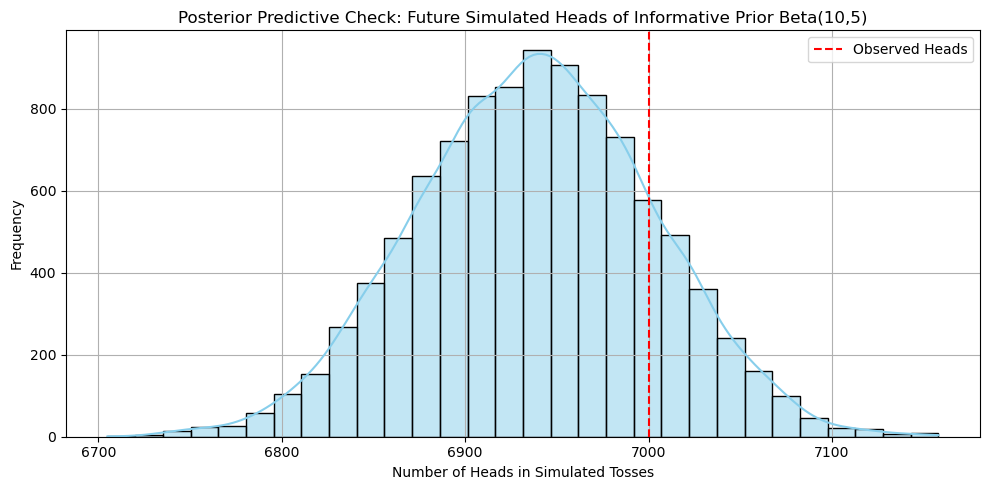

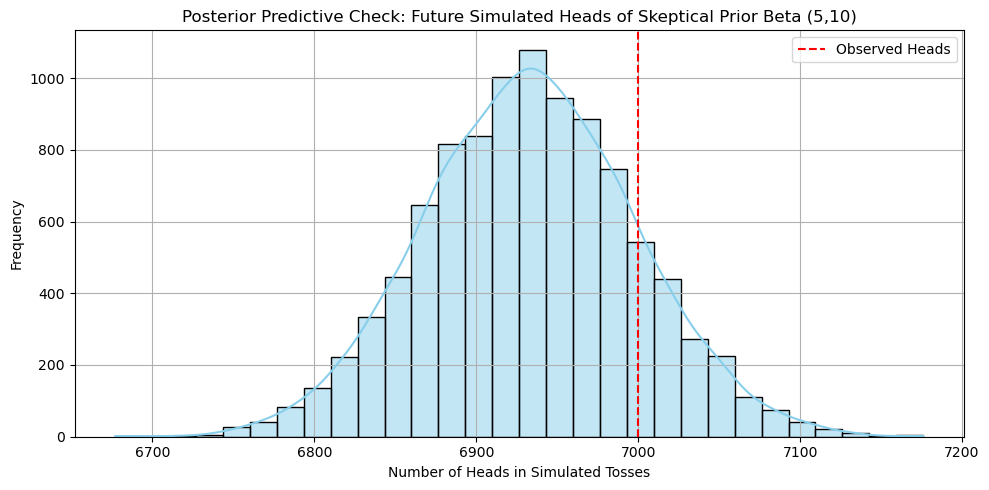

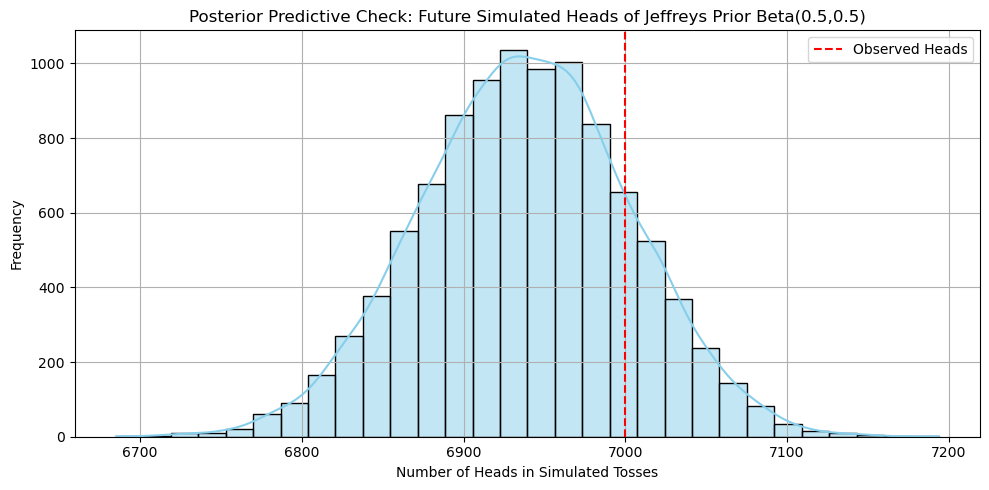

In [11]:
# Bayesian Step 1: Posterior Predictive Checks
# Simulate future coin tosses based on our posterior distribution to check whether the model "generates" realistic data

import seaborn as sns
sam_ps = {}
sim_head = {}
for lables, (a_post, b_post) in post.items():
    
    # Step 1: Sample 'p' values from the posterior
    sampled_ps = np.random.beta(a_post, b_post, size=10000)
    sam_ps[lables] = sampled_ps
    
    # Step 2: For each sampled p, simulate future coin tosses
    simulated_heads = np.random.binomial(10000, sampled_ps)
    sim_head[lables] = simulated_heads
    # Step 3: Compare Simulated results to actual observed heads
    plt.figure(figsize=(10,5))
    sns.histplot(simulated_heads, bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.axvline(7000, color='red', linestyle='--', label='Observed Heads')
    plt.title(f"Posterior Predictive Check: Future Simulated Heads of {lables}")
    plt.xlabel("Number of Heads in Simulated Tosses")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

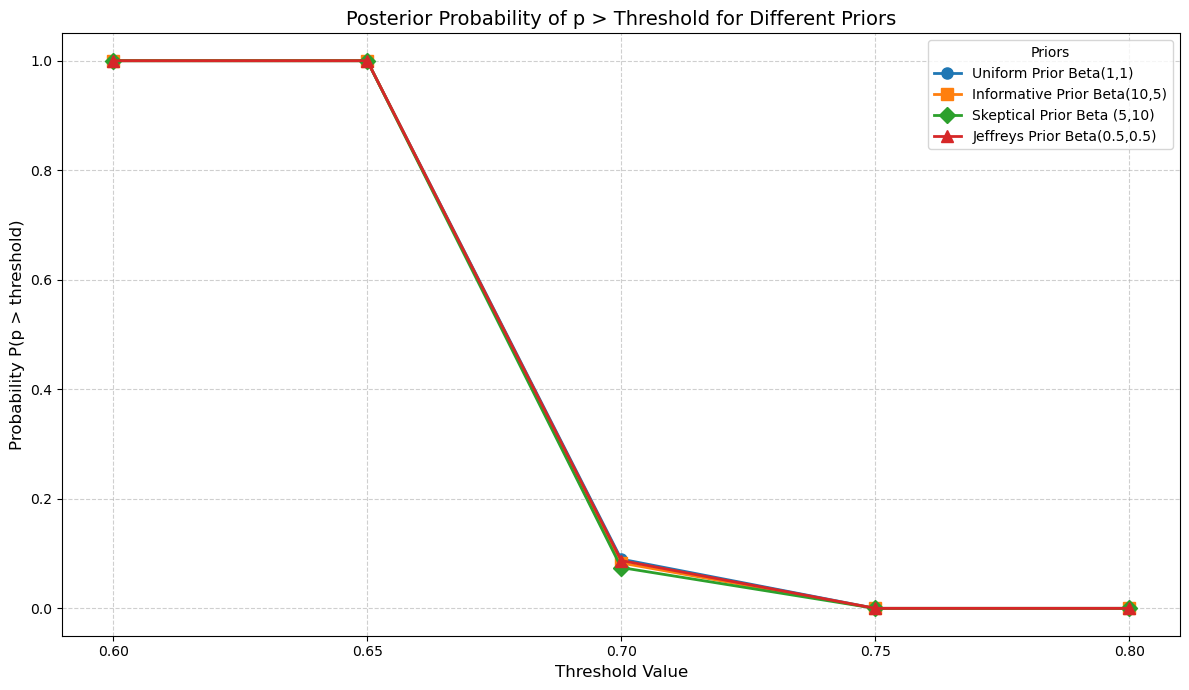

In [12]:
# Bayesian Step 2: Decision Threshold Analysis

all_p_above = {}
thresholds = [0.6,0.65,0.7,0.75,0.8]
for lables, samples in sam_ps.items():
    li_p = []
    for threshold in thresholds:
        p_above = np.mean(samples>threshold)
        li_p.append(p_above)
    all_p_above[lables] = li_p

# Improved visualization with style and clear separation
plt.figure(figsize=(12, 7))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', 'D', '^']

for (label, probs), color, marker in zip(all_p_above.items(), colors, markers):
    plt.plot(thresholds, probs, marker=marker, markersize=8, linewidth=2, label=label, color=color)

plt.title("Posterior Probability of p > Threshold for Different Priors", fontsize=14)
plt.xlabel("Threshold Value", fontsize=12)
plt.ylabel("Probability P(p > threshold)", fontsize=12)
plt.ylim(-0.05, 1.05)
plt.xticks(thresholds)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Priors", fontsize=10)
plt.tight_layout()
plt.show()

In [13]:
# Bayesian Step 3: Bayes Factor Model Comparison
# Here we devide the likelihood of our coin being biased to coin being fair.

from scipy.special import beta as b_fn
from scipy.stats import binom

# 1. Marginal likelihood under H0
m1_H0 = binom.pmf(7000,10000,0.5)

# 2. Marginal likelihood under H1 for each prior (via Monte Carlo)
bf_results = {}

for labels, ps in sam_ps.items():
    likelihood = binom.pmf(7000,10000,ps)
    m1_H1 = np.mean(likelihood)
    BF10 = m1_H1/m1_H0
    bf_results[labels] = BF10

bf_results

/var/folders/qg/223g_sd10rv1cgfts8v5wc940000gn/T/ipykernel_97579/1399144035.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  BF10 = m1_H1/m1_H0


{'Uniform Prior Beta(1,1)': inf,
 'Informative Prior Beta(10,5)': inf,
 'Skeptical Prior Beta (5,10)': inf,
 'Jeffreys Prior Beta(0.5,0.5)': inf}

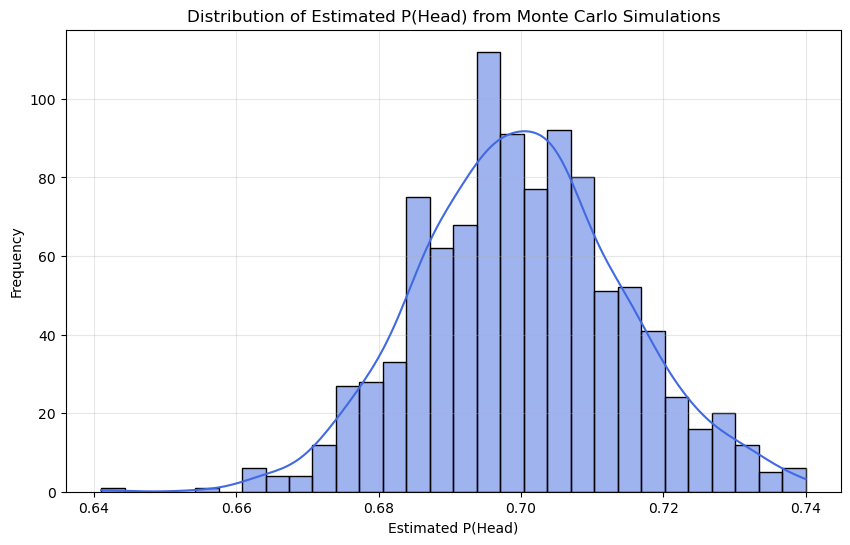

In [14]:
# 4. Monte Carlo Simulaton

estimates = []

for _ in range(1000):
    total_tosses = coin_flips(1000, 0.7)
    p_hat = np.sum(np.array(total_tosses) == 'H')/1000
    estimates.append(p_hat)

plt.figure(figsize=(10,6))
sns.histplot(estimates, bins=30, kde=True, color='royalblue')
plt.title("Distribution of Estimated P(Head) from Monte Carlo Simulations")
plt.xlabel("Estimated P(Head)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

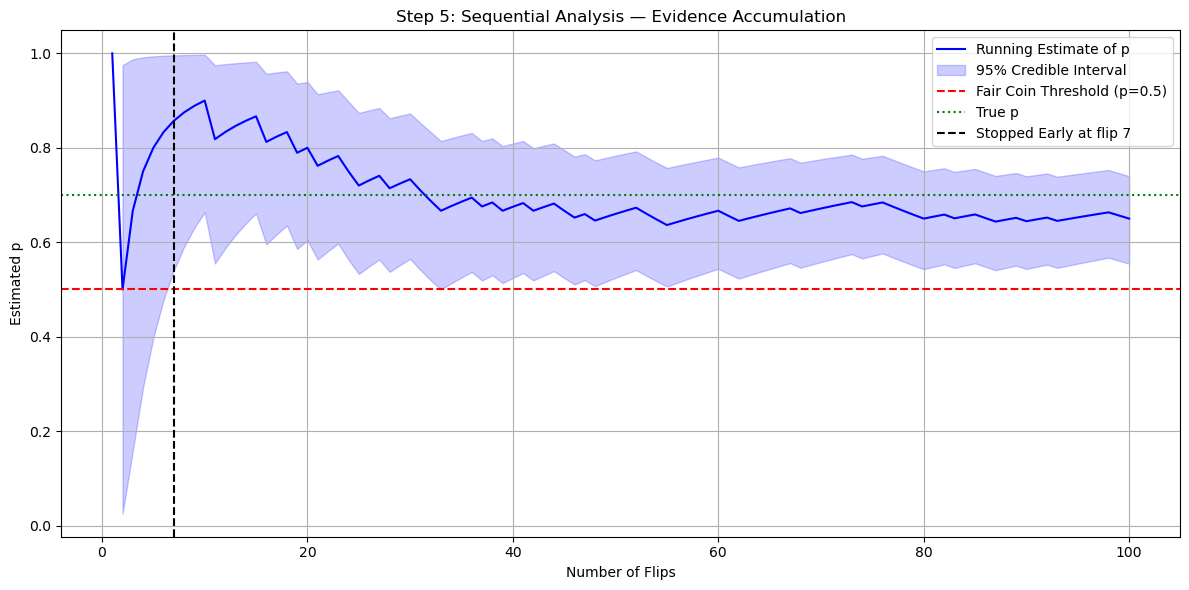

In [15]:
# 5. Sequential Analysis
# Early stopping the analysis when confident enough that our analysis is correct

from scipy.stats import beta

# True bias
true_p = 0.7
max_flips = 100
confidence_level = 0.95

# Simulate sequential flips
tosses = np.random.binomial(1, true_p, size=max_flips)

# Keep track
cumulative_heads = np.cumsum(tosses)
n_flips = np.arange(1, max_flips + 1)
estimates = cumulative_heads / n_flips

# Compute running credible intervals
lower_bounds = []
upper_bounds = []

for heads, flips in zip(cumulative_heads, n_flips):
    ci_lower, ci_upper = beta.ppf([(1 - confidence_level)/2, 1 - (1 - confidence_level)/2], heads, flips-heads)
    lower_bounds.append(ci_lower)
    upper_bounds.append(ci_upper)

# Determine stopping point
ci_excludes_05 = [(lo > 0.5) or (hi < 0.5) for lo, hi in zip(lower_bounds, upper_bounds)]
stop_index = next((i for i, x in enumerate(ci_excludes_05) if x), max_flips)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(n_flips, estimates, label='Running Estimate of p', color='blue')
plt.fill_between(n_flips, lower_bounds, upper_bounds, color='blue', alpha=0.2, label=f"{int(confidence_level*100)}% Credible Interval")
plt.axhline(0.5, color='red', linestyle='--', label='Fair Coin Threshold (p=0.5)')
plt.axhline(true_p, color='green', linestyle=':', label='True p')

if stop_index < max_flips:
    plt.axvline(stop_index + 1, color='black', linestyle='--', label=f"Stopped Early at flip {stop_index+1}")

plt.title("Step 5: Sequential Analysis — Evidence Accumulation")
plt.xlabel("Number of Flips")
plt.ylabel("Estimated p")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()